In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2

#### Import MNIST dataset - a large database of handwritten digits. 

In [48]:
mnist = pd.read_csv('mnist.csv')
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
label=list(mnist.label)
mnist.drop(columns='label', inplace=True)

#### Original and binary formats

Text(0.5, 1.0, 'Digit 0')

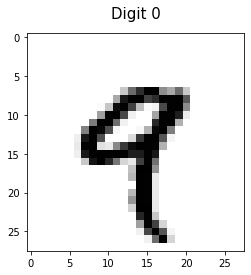

In [53]:
image = mnist.iloc[4].values.reshape([28,28])
plt.imshow(image, cmap='gray_r')
plt.title('Digit 0', fontsize=15, pad=15)

Text(0.5, 1.0, 'Digit 0')

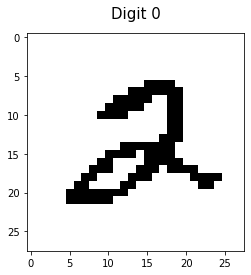

In [54]:
image = mnist.iloc[5].values.reshape([28,28])
image_bin = (image > 170) #make image binary
plt.imshow(image_bin, cmap='gray_r')
plt.title('Digit 0', fontsize=15, pad=15)

In [55]:
mnist_bin=mnist.applymap(lambda x: 1 if x>170 else 0)

### Apply PCA  for dimensionality reduction of array and increasing of learning rate
#### Choose the right number of dimensions

Text(0, 0.5, 'Explained variance')

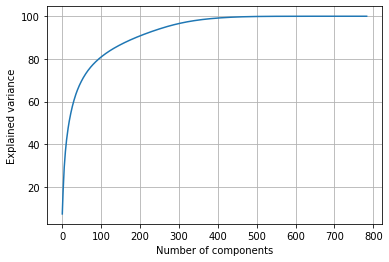

In [79]:
#----binary format----

pca_784 = PCA(n_components=784, random_state=42)
pca_784.fit(mnist_bin)

plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

Text(0, 0.5, 'Explained variance')

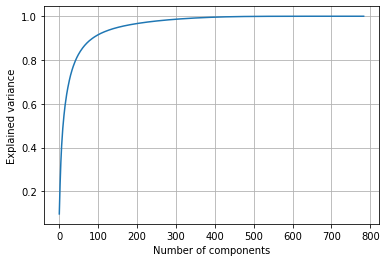

In [80]:
#-----original format-----
pca_784 = PCA(n_components=784, random_state=42)
pca_784.fit(mnist)

plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ ))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

#### It's clearly seen that, function grows faster if using non-binary format, so for further training we will use it.

#### Compressed image with 184 components`

Text(0.5, 1.0, 'Compressed image with 184 components')

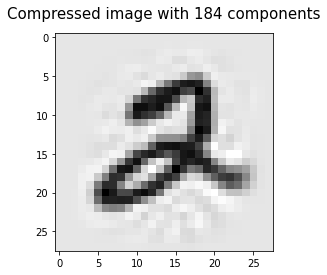

In [56]:
pca_184 = PCA(n_components=184, random_state=42)
mnist_pca_184_reduced = pca_184.fit_transform(mnist)
mnist_pca_184_recovered = pca_184.inverse_transform(mnist_pca_184_reduced)

image_pca_184 = mnist_pca_184_recovered[5,:].reshape([28,28])
plt.imshow(image_pca_184, cmap='gray_r')
plt.title('Compressed image with 184 components', fontsize=15, pad=15)

### Neural network with one hidden layer

#### Make training and hold-out datasets

In [65]:
#-----Make hold-out set (20%)-----
X=mnist_pca_184_reduced
y=label

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

shufflesplit = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=int(len(y)*0.2))


for train_index, test_index in shufflesplit.split(X, y):
    X_to_fit, y_to_fit = X[train_index] , [y[i] for i in train_index]
    X_hold_out, y_hold_out = X[test_index] , [y[i] for i in test_index]

In [66]:
def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

#### Neural network fitting

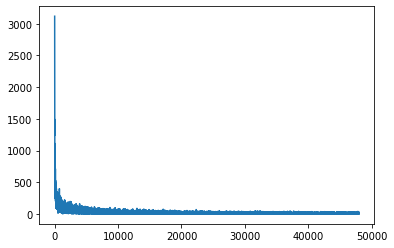

In [68]:
#HEAVILY BASED ON https://github.com/dkorobchenko-nv/nn-python/blob/main/train.py

INPUT_DIM = 184
OUT_DIM = 10
H_DIM = 20


W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

ALPHA = 0.000002
NUM_EPOCHS = 50
BATCH_SIZE = 50

loss_arr = []

dataset_to_fit=list(zip(X_to_fit, y_to_fit))
for ep in range(NUM_EPOCHS):
    random.shuffle(dataset_to_fit)
    for i in range(len(dataset_to_fit) // BATCH_SIZE):

        batch_x, batch_y = zip(*dataset_to_fit[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.array(batch_x)
        y = np.array(batch_y)

        # Forward
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        # Backward
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Update
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)


plt.plot(loss_arr)
plt.show()

#### Accuracy

In [74]:
def predict_prob(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy(dataset):
    correct = 0
    for x, y in dataset:
        z = predict_prob(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    y_pred = np.argmax(z)
    return y_pred

dataset_hold_out=list(zip(X_hold_out, y_hold_out))

accuracy = calc_accuracy(dataset_hold_out)
print("Accuracy:", accuracy)

Accuracy: 0.9350833333333334


In [76]:
y_predict=[predict(x) for x in X_hold_out]
pd.DataFrame({'number_pred': y_predict, 'number': y_hold_out})

,number_pred,number
0,7,7
1,2,7
2,3,3
3,5,5
4,6,6
...,...,...
11995,8,8
11996,4,4
11997,8,8
11998,6,6


#### Test handwritten digits drawn by me in "Paint"

In [86]:
img=cv2.imread('test_handwritten_digits/3_test.png')
print("Original image dimensions:", img.shape)

# resize image
dim=(28, 28)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions: ',resized.shape)
gray_img = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) 
print("1-channel image:", gray_img.shape)
gray_img=np.concatenate(gray_img)
result_img=(255-gray_img)

Original image dimensions: (95, 110, 3)
Resized Dimensions:  (28, 28, 3)
1-channel image: (28, 28)


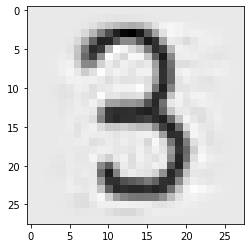

In [87]:
result_img=result_img.reshape(1, -1)
test=pca_184.transform(result_img)
test_recovered=pca_184.inverse_transform(test)
image=test_recovered.reshape([28,28])
plt.imshow(image, cmap='gray_r')

In [88]:
predict(test)

3

In [90]:
img=cv2.imread('test_handwritten_digits/2_test.png')
print("Original image dimensions:", img.shape)

# resize image
dim=(28, 28)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions: ',resized.shape)
gray_img = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) 
print("1-channel image:", gray_img.shape)
gray_img=np.concatenate(gray_img)
result_img=(255-gray_img)

Original image dimensions: (99, 122, 3)
Resized Dimensions:  (28, 28, 3)
1-channel image: (28, 28)


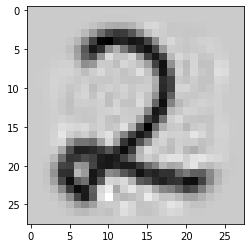

In [91]:
result_img=result_img.reshape(1, -1)
test=pca_184.transform(result_img)
test_recovered=pca_184.inverse_transform(test)
image=test_recovered.reshape([28,28])
plt.imshow(image, cmap='gray_r')

In [92]:
predict(test)

2

#### It's works!